## Global Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import time

## Setup Jupyter Notebook data visualisaton params

In [2]:
from pylab import rcParams
import seaborn as sb

%matplotlib inline
rcParams['figure.figsize'] = 15, 6
sb.set_style('whitegrid')

## Import dataset

In [3]:
address = '../../datasets/staandelamp_realistic.json'
df_data = pd.read_json(address)

# Sort the data on timestamp
df_data = df_data.sort_values(by=['time'])

# Grab around 6 hours of timestamps
### TEMP ###
df_data = df_data[:9]   #42
### TEMP ###
df_data.iloc[0, (2)]  = 1
df_data.iloc[1, (2)]  = 2
df_data.iloc[2, (2)]  = 3
df_data.iloc[3, (2)]  = 5
df_data.iloc[4, (2)]  = 7
df_data.iloc[5, (2)]  = 9
df_data.iloc[6, (2)]  = 18
df_data.iloc[7, (2)]  = 25
df_data.iloc[8, (2)]  = 26

print(df_data.shape)

df_data.head()

(9, 3)


,name,state,time
2,Staande_Lamp_3,0,1
6,Staande_Lamp_5,1,2
0,Staande_Lamp_1,1,3
1,Staande_Lamp_2,0,5
3,Staande_Lamp_3,1,7


# Determine the number of clusters (linkage)

#### only interested in column TIME

In [4]:

X = df_data.iloc[ :, [2] ].values
#                 :        All the rows
#                    [2]   Only column 2 (time)

X[:5]

array([[1],
       [2],
       [3],
       [5],
       [7]], dtype=int64)

##### Plot the timestamps and a line indicating 5 minutes

D:\Programs\Anaconda\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


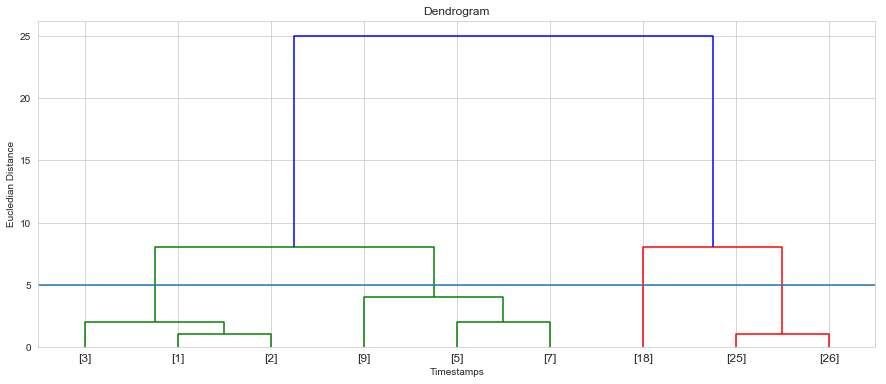

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X, method='complete')
gram = dendrogram(
    Z, 
    labels=X,
    # truncate_mode='lastp', 
    # p=12, 
    # leaf_rotation=45., 
    # leaf_font_size=15., 
    # show_contracted=True
)
plt.title('Dendrogram')
plt.xlabel('Timestamps')
plt.ylabel('Eucledian Distance')

# This line represents a distance of 5
plt.axhline(y=5)

In [6]:
# Debug Z

five_minutes = 5

print('Z[0][0]', Z[0][0])

clusters_with_distance_of_five_minutes_or_less = 0
for idx, val in enumerate(Z):
    
    print(
        '\nidx:', idx
    )
    # Count Z with a distance of less than 10 minutes
    if(val[2] < five_minutes): 
        print('< five_minutes: TRUE')
        clusters_with_distance_of_five_minutes_or_less += 1
    
    # debug a couple of the Z's
    # if(idx == 0 or idx == 1 or idx == 2 or idx == 30):
    print(
        'val:', val[0], '-', val[1], '-', val[2], '-', val[3], '\n'
    )

clusters = []

Z[0][0] 0.0

idx: 0
< five_minutes: TRUE
val: 0.0 - 1.0 - 1.0 - 2.0 


idx: 1
< five_minutes: TRUE
val: 7.0 - 8.0 - 1.0 - 2.0 


idx: 2
< five_minutes: TRUE
val: 2.0 - 9.0 - 2.0 - 3.0 


idx: 3
< five_minutes: TRUE
val: 3.0 - 4.0 - 2.0 - 2.0 


idx: 4
< five_minutes: TRUE
val: 5.0 - 12.0 - 4.0 - 3.0 


idx: 5
val: 11.0 - 13.0 - 8.0 - 6.0 


idx: 6
val: 6.0 - 10.0 - 8.0 - 3.0 


idx: 7
val: 14.0 - 15.0 - 25.0 - 9.0 



In [7]:
total_number_of_clusters = Z.shape[0]
print(
    clusters_with_distance_of_five_minutes_or_less, 
    'of', 
    total_number_of_clusters, 
    'clusters have a distance less than 5'
)

5 of 8 clusters have a distance less than 5


# AgglomerativeClustering

In [8]:
## Format the dataset to be all numbers

In [9]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

print('before:\n', df_data.head())

d = defaultdict(LabelEncoder)
df_fit = df_data.apply(lambda x: d[x.name].fit_transform(x))
df_fit['time'] = df_data['time']
print('after:\n', df_fit.head())

before:
              name  state  time
2  Staande_Lamp_3      0     1
6  Staande_Lamp_5      1     2
0  Staande_Lamp_1      1     3
1  Staande_Lamp_2      0     5
3  Staande_Lamp_3      1     7
after:
    name  state  time
2     2      0     1
6     4      1     2
0     0      1     3
1     1      0     5
3     2      1     7


In [10]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

# amountOfDataRows = df_fit['name'].size

model = AgglomerativeClustering(
    affinity='euclidean', 
    compute_full_tree='auto',
    connectivity=None, 
    linkage='complete', 
    memory=None, 
    n_clusters=clusters_with_distance_of_five_minutes_or_less,
    pooling_func='deprecated'
)

model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=5, pooling_func='deprecated')

In [11]:
#sm.accuracy_score(df_data.iloc[:, (2)], model.labels_)

predicted_clusters = model.fit(df_fit).labels_

In [12]:
# predicted_clusters = model.fit_predict(df_fit)
# predicted_clusters

In [13]:
### Find outliers

In [14]:
outlier_dict = {}
for i in model.labels_: outlier_dict[i] = i in outlier_dict
outliers = [k for k in outlier_dict if not outlier_dict[k]]

print('outliers:\n', outliers)

outliers:
 [2]


In [15]:
### Make a color map for all groups and outliers (for plotting)

In [16]:
COLOR_MAP = {}
group_count = 0;
for n in set(model.labels_):
    if n in outliers:
        COLOR_MAP[n] = 'lightgrey'
    else:
        if group_count % 7 == 0:
            COLOR_MAP[n] = 'firebrick'
        elif group_count % 7 == 1:
            COLOR_MAP[n] = 'darkgreen'
        elif group_count % 7 == 2:
            COLOR_MAP[n] = 'purple'
        elif group_count % 7 == 3:
            COLOR_MAP[n] = 'darkorange'
        elif group_count % 7 == 4:
            COLOR_MAP[n] = 'Teal'
        elif group_count % 7 == 5:
            COLOR_MAP[n] = 'Olive'
        elif group_count % 7 == 6:
            COLOR_MAP[n] = 'Green'
        else:
            COLOR_MAP[n] = 'darkblue'
        group_count += 1

print('All of the datapoints:\n', model.labels_)
print('One color for each datapoint:\n', set(model.labels_))

All of the datapoints:
 [1 1 0 0 3 3 2 4 4]
One color for each datapoint:
 {0, 1, 2, 3, 4}


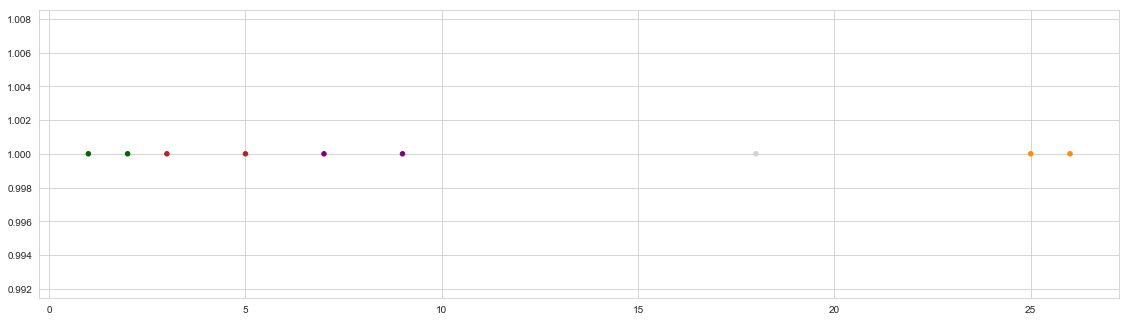

In [17]:
# Make figure smaller:
rcParams['figure.figsize'] = 15, 4

fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])

colors = [COLOR_MAP[l] for l in model.labels_]

# use first column as X value
XX = df_fit.iloc[:,2]
# set nr 1 as the value for y so it will be 1Dimentional
YY = [1] * df_fit.shape[0]

ax.scatter(XX, YY, c=colors, s=20)
ax.set_xlabel = 'time'
plt.title = 'Groupingz'
